# LGBM Inference

In [24]:
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

## 데이터 로드

In [25]:
train = pd.read_csv('/opt/ml/input/data/train_dataset/train_after.csv')
valid = pd.read_csv('/opt/ml/input/data/train_dataset/valid_after.csv')
test = pd.read_csv('/opt/ml/input/data/train_dataset/test_after.csv')

In [26]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,last_problem,left_asymptote,elo_prob,hour,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,600,1,2020-03-24 00:17:11,7224,0,0,0.978221,0,...,0.0,0.00,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,600,1,2020-03-24 00:17:14,7225,0,0,0.968121,0,...,3.0,3.00,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,600,1,2020-03-24 00:17:22,7225,0,0,0.940058,0,...,11.0,5.50,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,600,1,2020-03-24 00:17:29,7225,0,0,0.970276,0,...,18.0,6.00,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,600,1,2020-03-24 00:17:36,7225,0,0,0.956241,0,...,25.0,6.25,7,2,2.079442,3,0.714286,5,0,0


In [27]:
valid.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,last_problem,left_asymptote,elo_prob,hour,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,35,A040093001,400,1,2020-01-02 23:30:13,2094,0,0,0.951880,23,...,0.0,0.000000,5,1,0.000000,0,0.2,1,0,0
1,35,A040093002,400,0,2020-01-02 23:31:13,2094,0,0,0.777700,23,...,60.0,60.000000,5,1,4.110874,1,0.4,2,0,0
2,35,A040093003,400,0,2020-01-02 23:31:56,2094,0,0,0.470429,23,...,103.0,51.500000,5,1,3.784190,2,0.6,3,0,0
3,35,A040093004,400,0,2020-01-02 23:32:15,2094,0,0,0.255394,23,...,122.0,40.666667,5,1,2.995732,3,0.8,4,0,0
4,35,A040093005,400,1,2020-01-02 23:35:06,2094,-1,0,0.530134,23,...,293.0,73.250000,5,1,5.147494,4,1.0,5,0,0


In [28]:
# LEAVE LAST INTERACTION ONLY
test = test[test['userID'] != test['userID'].shift(-1)]
# DROP ANSWERCODE
test = test.drop(['answerCode'], axis=1)

In [29]:
test.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,last_problem,left_asymptote,elo_prob,hour,dow,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
1035,3,A050133008,501,2020-10-26 13:13:57,5289,-1,0,0.445639,13,0,...,46604.0,54.127758,8,2,3.850148,11,1.0,8,0,0
1706,4,A070146008,701,2020-12-27 02:47:54,9080,-1,0,0.136933,2,6,...,24486.0,57.614118,8,2,3.178054,3,1.0,8,0,0
3023,13,A070111008,701,2020-12-27 04:35:09,9660,-1,0,0.150526,4,6,...,9485.0,19.396728,8,3,2.197225,6,1.0,8,0,0
4283,17,A090064006,900,2020-10-30 05:48:37,2611,-1,0,0.520654,5,4,...,19535.0,47.415049,6,1,4.330733,5,1.0,6,0,0
4670,26,A060135007,601,2020-10-23 11:44:18,1422,-1,0,0.327865,11,4,...,11539.0,34.547904,7,1,2.890372,6,1.0,7,0,0


## 카테고리 피쳐 라벨링

In [30]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','hour','dow','solved_disorder','KnowledgeTag','testId','retest']

# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
# 사용할 Feature 설정
FEATS = ['last_problem', 'elapsed', 'grade', 'prior_KnowledgeTag_frequency','KnowledgeTag','testId','retest','hour','dow',"hour_mean", 'hour_sum', "dow_mean", 'dow_sum',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'elo_prob',
       'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
       'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
       'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
       'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
       'problem_position', 'solve_order', 'solved_disorder']

# FEATS = ['GradeAcc', 
# 'ass_mean', 
# 'RepeatedTime', 
# 'elo_prob', 
# 'ass_elp_o', 
# 'GradeMElp', 
# 'elapsed', 
# 'ass_elp_x', 
# 'grade', 'Grade_o', 
# 'GradeElp', 
# 'user_acc',
#  'test_mean', 
# 'ass_sum', 
# 'KnowledgeTag',
#  'tag_elp_x', 
# 'GradeCount', 
# 'user_correct_answer']


In [32]:
# ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
#        'KnowledgeTag', 'last_problem', 'elapsed', 'grade', 'mid',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
#        'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
#        'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
#        'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
#        'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
#        'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
#        'problem_position', 'solve_order', 'solved_disorder']

# categorical 처리!!!

In [33]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [34]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)

## 4. 훈련 및 검증

In [35]:
'''
    original
'''
model = lgb.train(
                    {'objective': 'binary','metric':'auc', 'scale_pos_weight':1.5, 'boosting':'dart'},
#                     {'objective': 'binary','metric':'auc','boosting':'dart',
#                      'learning_rate':0.05,'max_depth':15,'feature_fraction':0.8},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=2500,
                    early_stopping_rounds=200
                )

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1316760, number of negative: 695809
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6465
[LightGBM] [Info] Number of data points in the train set: 2012569, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654268 -> initscore=0.637854
[LightGBM] [Info] Start training from score 0.637854


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's auc: 0.846885	valid_1's auc: 0.850607
[200]	training's auc: 0.849646	valid_1's auc: 0.853532
[300]	training's auc: 0.851852	valid_1's auc: 0.856237
[400]	training's auc: 0.853135	valid_1's auc: 0.857659
[500]	training's auc: 0.854384	valid_1's auc: 0.858807
[600]	training's auc: 0.854921	valid_1's auc: 0.859422
[700]	training's auc: 0.855566	valid_1's auc: 0.859972
[800]	training's auc: 0.856056	valid_1's auc: 0.860357
[900]	training's auc: 0.856666	valid_1's auc: 0.860685
[1000]	training's auc: 0.857076	valid_1's auc: 0.860913
[1100]	training's auc: 0.857527	valid_1's auc: 0.861086
[1200]	training's auc: 0.857823	valid_1's auc: 0.861242
[1300]	training's auc: 0.858196	valid_1's auc: 0.861514
[1400]	training's auc: 0.858751	valid_1's auc: 0.861722
[1500]	training's auc: 0.859057	valid_1's auc: 0.861787
[1600]	training's auc: 0.859455	valid_1's auc: 0.861923
[1700]	training's auc: 0.859976	valid_1's auc: 0.862032
[1800]	training's auc: 0.86035	valid_1's auc: 0.862024
[1

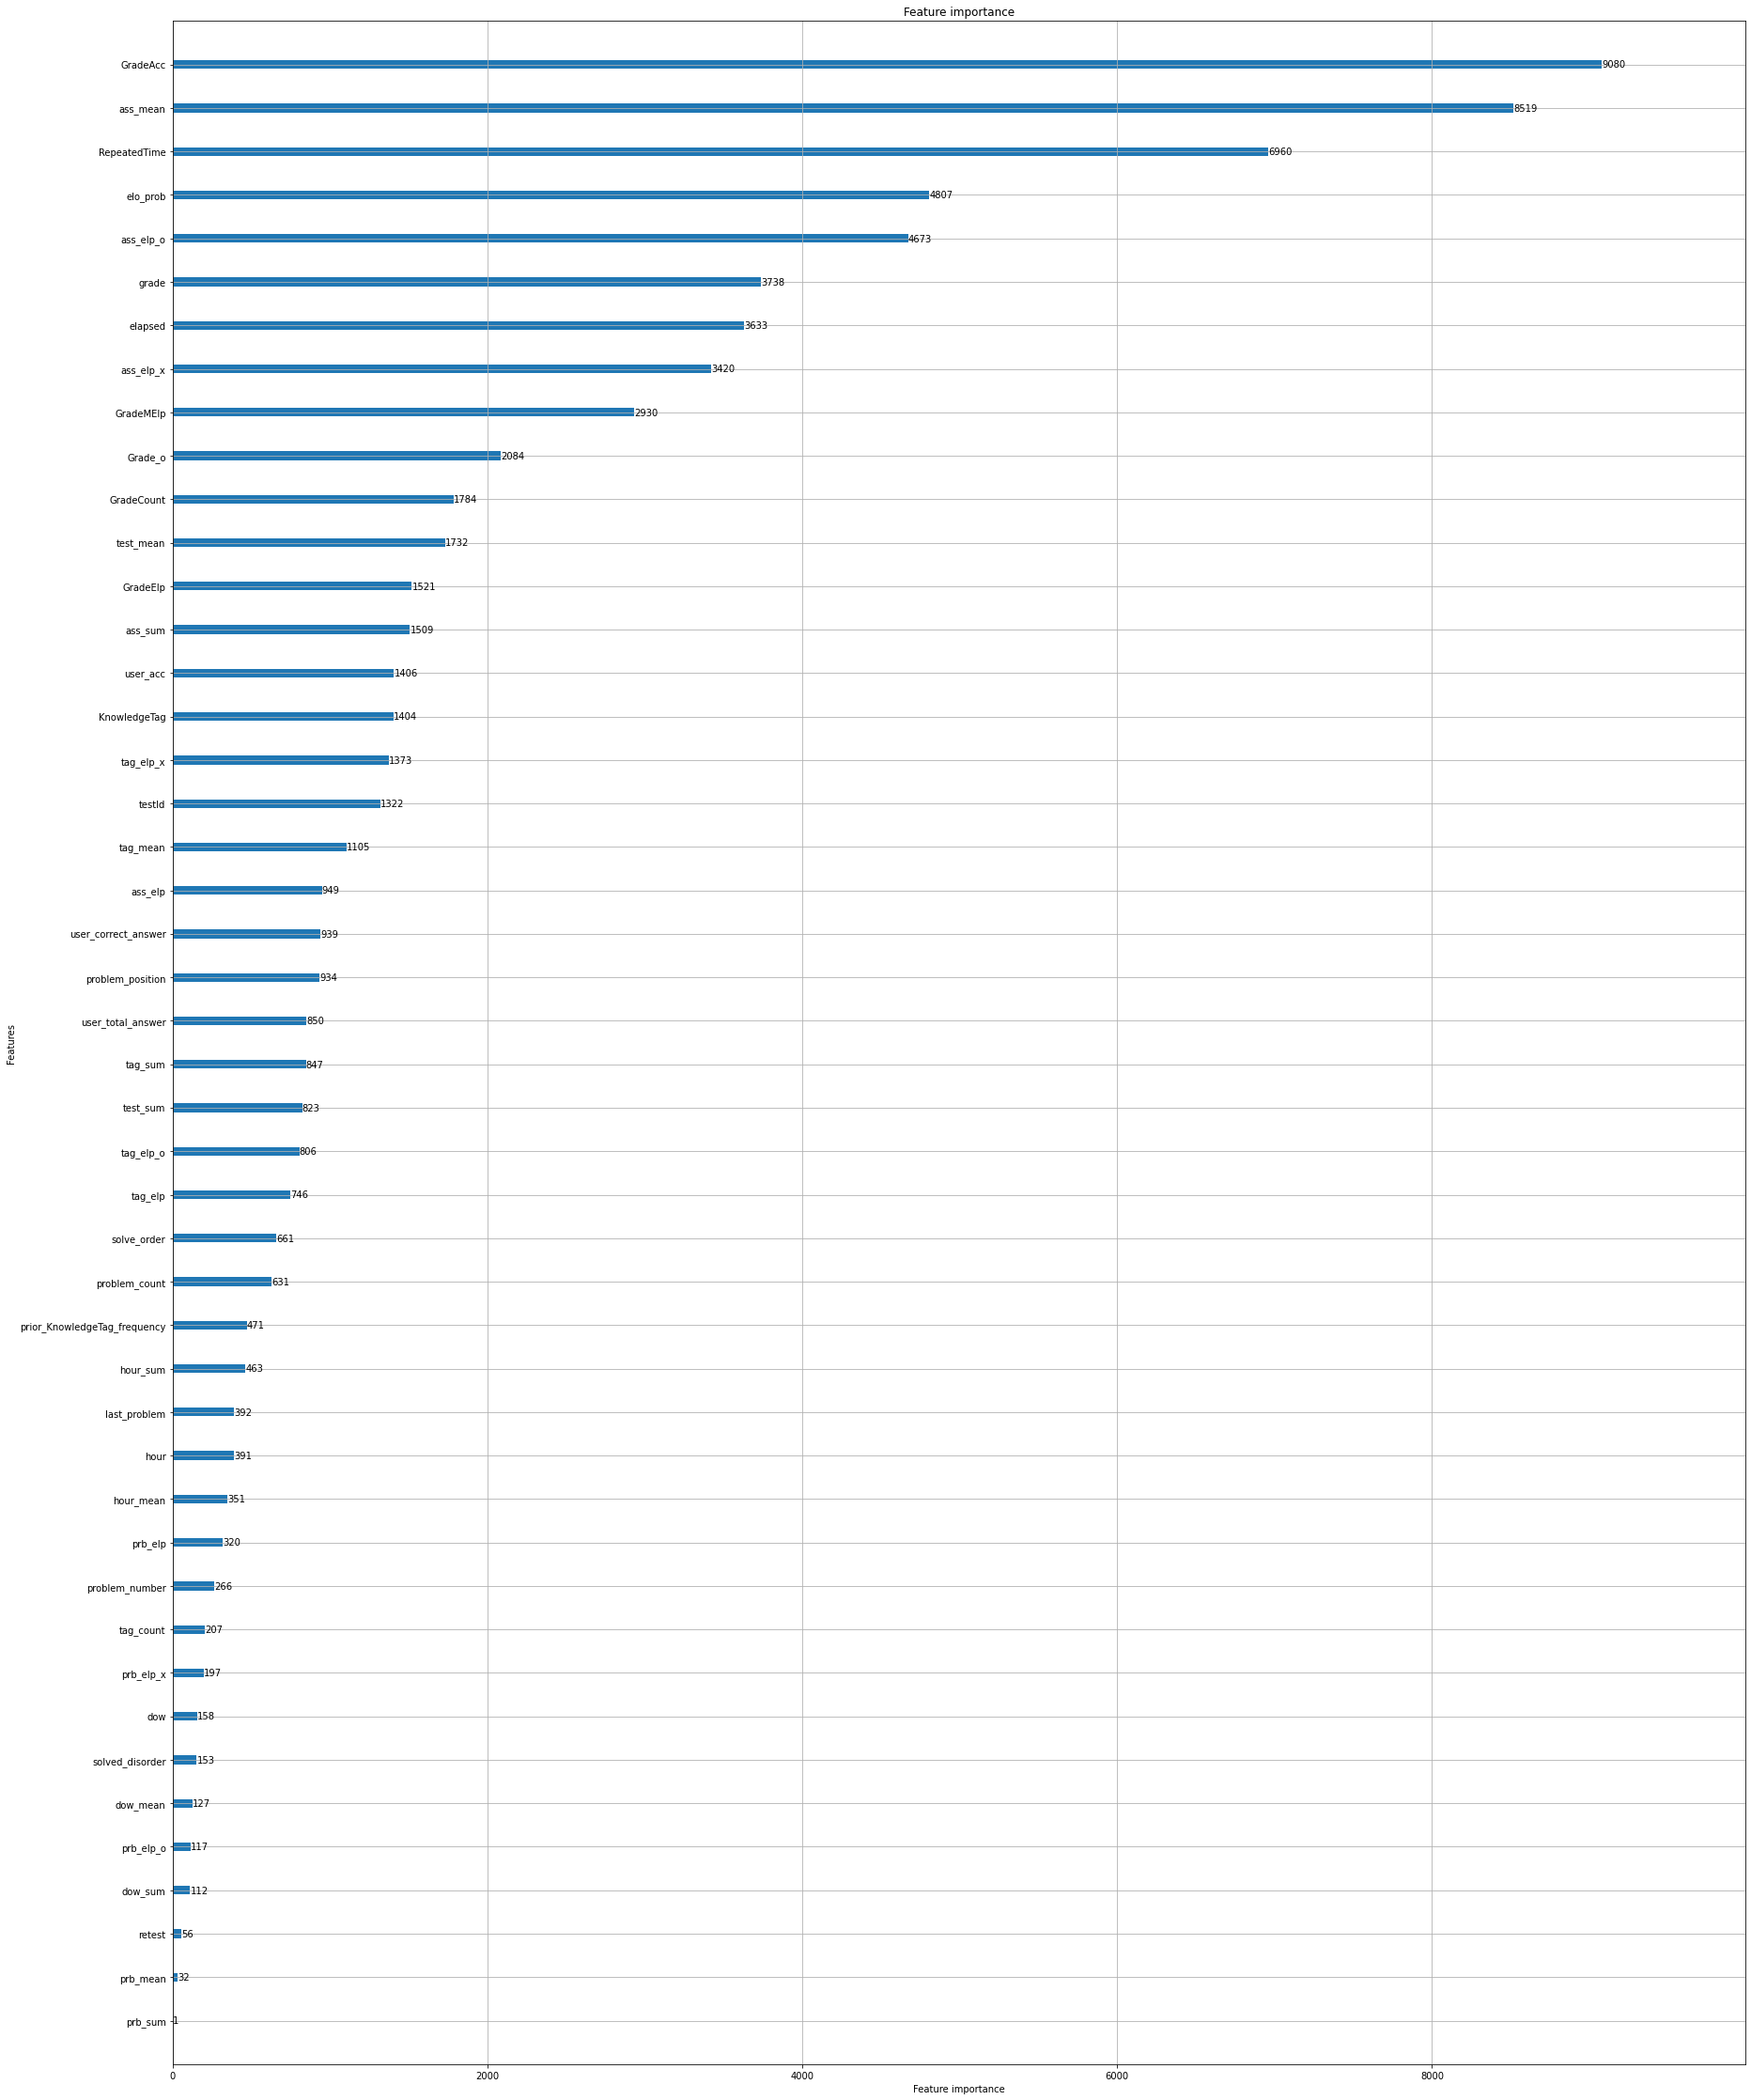

In [37]:
# Feature Importance 파악
import matplotlib.pyplot as plt
ax = lgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(30, 40)

## Inference

In [38]:
train.head()

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,last_problem,left_asymptote,elo_prob,hour,dow,...,GradeElp,GradeMElp,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,10,2020-03-24 00:17:11,556,0,0,0.978221,0,1,...,0.0,0.00,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,10,2020-03-24 00:17:14,557,0,0,0.968121,0,1,...,3.0,3.00,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,10,2020-03-24 00:17:22,557,0,0,0.940058,0,1,...,11.0,5.50,7,2,2.197225,1,0.428571,3,0,0
3,0,A060001004,10,2020-03-24 00:17:29,557,0,0,0.970276,0,1,...,18.0,6.00,7,2,2.079442,2,0.571429,4,0,0
4,0,A060001005,10,2020-03-24 00:17:36,557,0,0,0.956241,0,1,...,25.0,6.25,7,2,2.079442,3,0.714286,5,0,0


In [39]:
test.columns

Index(['userID', 'assessmentItemID', 'testId', 'Timestamp', 'KnowledgeTag',
       'last_problem', 'left_asymptote', 'elo_prob', 'hour', 'dow', 'elapsed',
       'grade', 'mid', 'problem_number', 'test_mean', 'test_sum', 'tag_mean',
       'tag_sum', 'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'hour_mean',
       'hour_sum', 'dow_mean', 'dow_sum', 'tag_elp', 'tag_elp_o', 'tag_elp_x',
       'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp', 'prb_elp_o',
       'prb_elp_x', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp', 'GradeMElp',
       'problem_count', 'tag_count', 'RepeatedTime',
       'prior_KnowledgeTag_frequency', 'problem_position', 'solve_order',
       'retest', 'solved_disorder'],
      dtype='object')

In [40]:
# MAKE PREDICTION
total_preds = model.predict(test[FEATS])

In [41]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_scale_1.5_modify_features (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_scale_1.5_modify_features (dart).csv


In [23]:
total_preds

array([0.37765264, 0.71753062, 0.25640062, 0.92446524, 0.54980025,
       0.92971537, 0.05598646, 0.36409839, 0.19939544, 0.30751351,
       0.50470829, 0.21542888, 0.99372513, 0.12612558, 0.86301995,
       0.96992566, 0.18193099, 0.88623721, 0.90760362, 0.18684466,
       0.96496233, 0.69896413, 0.79920938, 0.37310875, 0.41926142,
       0.76415525, 0.98727735, 0.93760682, 0.67299863, 0.82222905,
       0.86304948, 0.71475525, 0.95559142, 0.11968058, 0.90035375,
       0.96621727, 0.20576779, 0.48606961, 0.42231383, 0.27252655,
       0.78905602, 0.1238077 , 0.25985515, 0.48428081, 0.6012676 ,
       0.82069141, 0.76440419, 0.3147187 , 0.98543255, 0.84780994,
       0.66960958, 0.37489338, 0.4976033 , 0.17327323, 0.62079605,
       0.78405432, 0.50521397, 0.97020334, 0.17394718, 0.28677705,
       0.90803483, 0.95901467, 0.96424277, 0.26538683, 0.15550671,
       0.52435545, 0.88621143, 0.30455674, 0.26421048, 0.33522155,
       0.91438552, 0.93421265, 0.21503871, 0.5048213 , 0.45808

In [99]:
total_preds

array([0.39728014, 0.63445421, 0.2176951 , 0.83896455, 0.41841521,
       0.89363904, 0.0798989 , 0.35235454, 0.15498924, 0.28316705,
       0.48893303, 0.15337316, 0.98967888, 0.08397487, 0.83071587,
       0.95062693, 0.1303916 , 0.83944502, 0.91940489, 0.18734109,
       0.94667468, 0.63598795, 0.71596152, 0.34771912, 0.27061104,
       0.55803151, 0.98707348, 0.92239358, 0.59249188, 0.67193864,
       0.79447213, 0.61225714, 0.93004352, 0.12208847, 0.85868437,
       0.95245936, 0.16225706, 0.46050912, 0.45753899, 0.21103229,
       0.72036321, 0.10603394, 0.19755021, 0.35423983, 0.47859176,
       0.79948596, 0.67944365, 0.24341369, 0.9723708 , 0.78636922,
       0.58270628, 0.25183621, 0.32568025, 0.14050936, 0.48899244,
       0.69680751, 0.39156604, 0.96993114, 0.08991392, 0.17630733,
       0.87158672, 0.93160497, 0.95424715, 0.20552828, 0.12891612,
       0.40024939, 0.8525725 , 0.221418  , 0.2003288 , 0.28167006,
       0.90008818, 0.87655754, 0.15972994, 0.22080345, 0.38098